So now let's create a notebook to demonstrate how our sytem of models behaves A random user of this system all he has to do is:

a) Firstly save the 9 models deployed in the previous notebook in a subdirectory called models_new in the same directory where the current notebook (of the implementation) is saved

b) Use a png picture of the face of a person for predictions. Since these models have been trained with faces very zoomed in, obviously the results will be better if the png picture uploaded be as zoomed as possible in the face of the person. This png picture must be saved in a path into the mother directory where the current notebook (of the development) is saved. Then the function final_rediction will be used , that will take as input only this path where this png picture is saved

So let's show how it's done

FIrstly let's import all the necessary modules 

In [1]:
import pandas as pd
import numpy as np
import cv2
from skimage import io
import os
import glob
from scipy.spatial import distance
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.utils import to_categorical, plot_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from keras.layers.merge import concatenate
from keras.layers import Dense
from keras.models import Model
from keras.layers import Input
import keras.layers as l
import keras.models as m
import tensorflow  
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras import backend as K
from keras.layers import Activation
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import glob
from xml.etree import ElementTree
from tensorflow.keras.models import load_model
import imageio
from keras_preprocessing.image import ImageDataGenerator
import random
from tqdm import tqdm
import operator
import imageio

In [2]:
#Since the models are saved in h5 format and we have used a custom function in some of them (Lecun_), we should firstly 
#define it and then call it as a custom_object

def Lecun_(x):
    tan_h=K.tanh(x) #hyperbolic tan function
    t=1.7159*(tan_h)+0.01*x #lecun function
    return t

Now let's load our models and save them in a list called members

In [3]:
def load_all_models(n_models):
    all_models = list()
    for i in range(n_models):
        # define filename for this ensemble
        filename = 'models_new/model_' + str(i + 1) +'.h5' 
        # load model from file
        model = load_model(filename,custom_objects={"Lecun_": Lecun_ })
        # add to list of members
        all_models.append(model)
        print('>loaded %s' % filename)
    return all_models

# load all models
n_members = 9
members = load_all_models(n_members)

>loaded models_new/model_1.h5
>loaded models_new/model_2.h5
>loaded models_new/model_3.h5
>loaded models_new/model_4.h5
>loaded models_new/model_5.h5
>loaded models_new/model_6.h5
>loaded models_new/model_7.h5
>loaded models_new/model_8.h5
>loaded models_new/model_9.h5


So we have loaded all the 9 models that will be used for the final model. These models,as mentioned above, are saved in the same directory as the one where this notebook is executed, into the subdirectory models_new. 

Our proposal for the final Model will be robust to adversarial examples. But before showing that, let's firstly explain how this system of models will make the predictions.

We will exploit all the 9 models created and each time we need a prediction, all these models will be used to produce a prediction. Then the majority of them will win meaning that if for example 7 predictions are made for 0 and 5 for 1 then the prediction will be 0.

Remember 

0 is for not wearing the mask properly

1 is for wearing the mask properly

2 is for not wearing a mask at all



Below we will demonstrate the way on showing how to use just one of the 9 models. In this case we have created a directory called photos_example in the same folder where our notebook is saved, and there we saved some pictures taken by our team. 0.png is the photo of a woman wearing a mask the wrong way,1.png of a man wearing it the correct way,  2.png and 22.png of a man and a woman respectively not wearing a mask, 00.png of a man not wearing a mask properly and 11.png of a man wearing the mask properly. We will create a function called initial_prediction

In [4]:
def initial_prediction(path,model_num):
    #This function takes as input the path of the picture stored in png format (the path after the directory of the mother
    #directory where this notebook is saved) and model_num a number inserted by the user between 1-12 which will indicate
    #which model will be exploited for the initial prediction
    
    image = io.imread(path)
    print('The original image')
    plt.imshow(image)
    plt.show()
    print('The rescaled image')
    res = cv2.resize(image, dsize=(60, 60), interpolation=cv2.INTER_CUBIC)
    plt.imshow(res)
    plt.show()
    res = res.astype('float32')
    res/=255
    res=res.reshape(1,60,60,3)
    print ('The prediction for that image is:', np.argmax(members[model_num-1].predict(res)))
    

Let's see some predictions. Many of them might be wrong since just 1 of the 9 models will be exploited

The original image


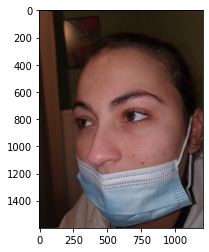

The rescaled image


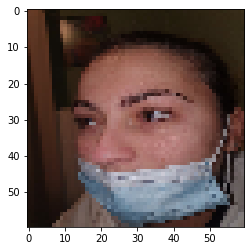

The prediction for that image is: 0


In [5]:
initial_prediction('photos_example/0.png',5)

The original image


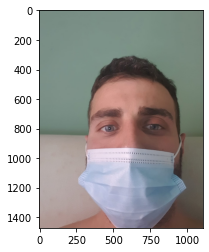

The rescaled image


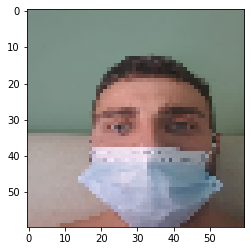

The prediction for that image is: 2


In [6]:
initial_prediction('photos_example/1.png',8)

The original image


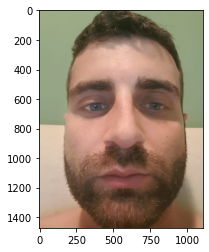

The rescaled image


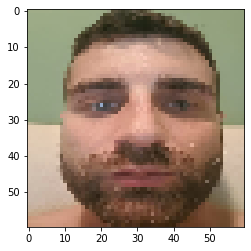

The prediction for that image is: 2


In [7]:
initial_prediction('photos_example/2.png',2)

The original image


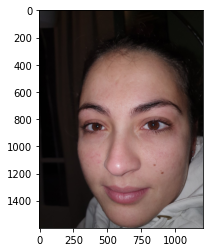

The rescaled image


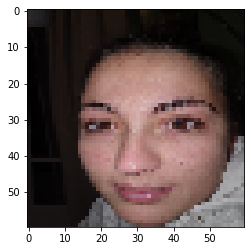

The prediction for that image is: 2


In [8]:
initial_prediction('photos_example/22.png',8)

The original image


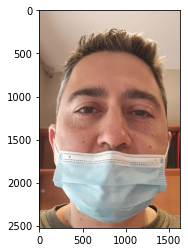

The rescaled image


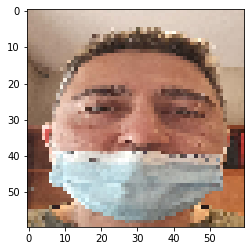

The prediction for that image is: 0


In [9]:
initial_prediction('photos_example/00.png',7)

The original image


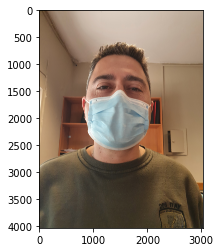

The rescaled image


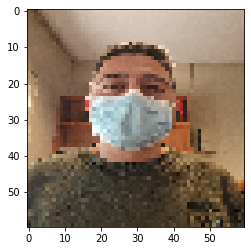

The prediction for that image is: 1


In [10]:
initial_prediction('photos_example/11.png',9)

Now let's create our final function for predictions

In [11]:
def final_prediction(path):
    #The logic of this function has been explained above. But the clue is that if there is a tie in the predictions of the model
    # (meaning for example that there are 6 models that predict 1 and 6 models that predict 2), then the individual percentages
    # will of each prediction will be exploited in order to produce a final result. (toy example - if you just had 2 models 
    # and the first predicted 1 with 90 % certainity and the second predicted 0 with 80 % certainity then you would choose 
    # 1 as your prediction)
    
    image = io.imread(path)
    print('The original image')
    plt.imshow(image)
    plt.show()
    print('The rescaled image')
    res = cv2.resize(image, dsize=(60, 60), interpolation=cv2.INTER_CUBIC)
    plt.imshow(res)
    plt.show()
    res = res.astype('float32')
    res/=255
    res=res.reshape(1,60,60,3)
    Dict_1 = {'0': 0 , '1': 0 , '2': 0}
    Dict_2 = {'0': 0 , '1': 0 , '2': 0}
    for i in range (len(members)):
        list_pred=members[i].predict(res)
        prediction=np.argmax(list_pred)
        Dict_1[str(prediction)]+=1
        Dict_2['0']+=list_pred[0][0]
        Dict_2['1']+=list_pred[0][1]
        Dict_2['2']+=list_pred[0][2]
    
    itemMaxValue = max(Dict_1.items(), key=lambda x: x[1])
    listOfKeys = list() 
    for key, value in Dict_1.items():
        if value == itemMaxValue[1]:
            listOfKeys.append(key)
            
    if len(listOfKeys)==1: # unique max vlaue of the predictions
        print ('The prediction for that image is:', int(max(Dict_1, key = Dict_1.get) ))
    else:                 #not unique max value of the predictions
        print ('The prediction for that image is:', int(max(Dict_2, key = Dict_2.get) ))

Now let's see some predictions with our final function

The original image


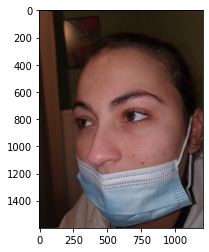

The rescaled image


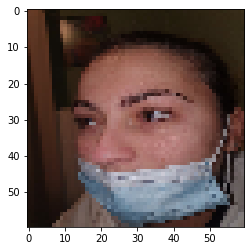

The prediction for that image is: 0


In [12]:
final_prediction('photos_example/0.png')

The original image


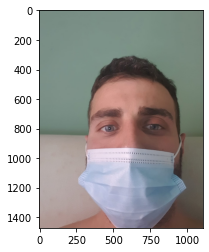

The rescaled image


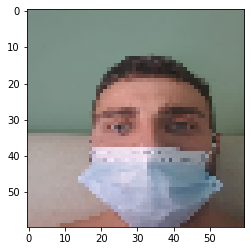

The prediction for that image is: 1


In [13]:
final_prediction('photos_example/1.png')

The original image


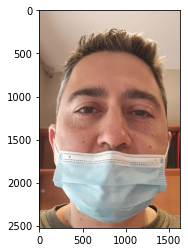

The rescaled image


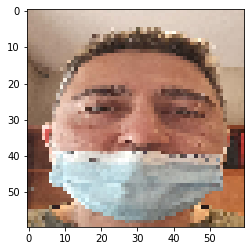

The prediction for that image is: 0


In [14]:
final_prediction('photos_example/00.png')

########################################################################################

Now let's check if our system of models will be robust and reliable against a GAN attack

For that reason we will create a function that will randomly return 1 of the 9 models that are deployed for the predictions.

In [15]:
def Final_Model_Masks(): 
    z=random.randint(1,len(members))
    return members[z-1]

Then, as we did in exercise 2, we will create another function that is used to create adversarial examples of photos 

In [16]:
# So this function takes as input one digit (integer), in order to rename the layers of the GAN model created each time, so that 
# we avoid the unique layer name' issue. Also, each time a new GAN will be created , so the models that compose the GAN, will 
# be deleted every time the function GAN_4 is called, if they have been created again before (in that case, erase_ old _models should be
# 'yes as an input'

def GAN_4(digit,erase_old_models):
    global advModel_4
    global wholeModel_4
    if erase_old_models=='yes':
        del advModel_4
        del wholeModel_4
    
    final_model_2=Final_Model_Masks()
    final_model_2.trainable = False

    _4_Input = l.Input(shape=(1,),name='4_Input_'+str(digit))
    _4_hidden = l.Dense(256, activation='relu',name='4_hidden_1_'+str(digit))(_4_Input)
    _4_hidden = l.Dense(60*60*3, activation="sigmoid",name='4_hidden_2_'+str(digit))(_4_hidden)
    _4_output = l.Reshape((60, 60,3),name='4_output_'+ str(digit))(_4_hidden)

    advModel_4 = m.Model(_4_Input, _4_output)
    advModel_4.compile(
    loss='mean_squared_error',
    optimizer=tf.optimizers.Adam(learning_rate=0.01),
    metrics=[tf.keras.metrics.RootMeanSquaredError()]

    )




    wholeModel_4 = m.Model(_4_Input, final_model_2(_4_output))
    wholeModel_4.compile(
    loss='categorical_crossentropy',
    optimizer=tf.optimizers.Adam(learning_rate=0.009),
    metrics=["accuracy"]
    )
    

Let's take a first glimpse of how our GAN looks. We will initiate firstly the GAN_4 function

In [17]:
GAN_4(0,'no')
advModel_4.summary() #our generator model
wholeModel_4.summary() # the whole GAN model

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 4_Input_0 (InputLayer)      [(None, 1)]               0         
                                                                 
 4_hidden_1_0 (Dense)        (None, 256)               512       
                                                                 
 4_hidden_2_0 (Dense)        (None, 10800)             2775600   
                                                                 
 4_output_0 (Reshape)        (None, 60, 60, 3)         0         
                                                                 
Total params: 2,776,112
Trainable params: 2,776,112
Non-trainable params: 0
_________________________________________________________________
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 4_Input_0 (InputLayer)      [(Non

So the GAN function has created a model that will be used to produce adversarial pictures given a real picture. Let's use a png file (a photo that our team has taken saved as 2.png in the subdirectory photos_example of the directory where the current notebook is stored). Just to be sure (as it will be shown in the above kernel), this was a png file which all of our 9 sub models predicted correcty. So any of these submodels that was randomly used from the Final_Model_Mask function that was used into our GAN function, initially predicted correclty the outcome of that image

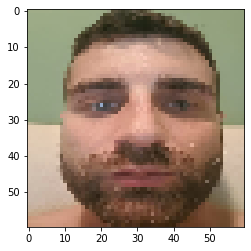

The prediction for model 1  is:  2
The prediction for model 2  is:  2
The prediction for model 3  is:  2
The prediction for model 4  is:  2
The prediction for model 5  is:  2
The prediction for model 6  is:  2
The prediction for model 7  is:  2
The prediction for model 8  is:  2
The prediction for model 9  is:  2


In [18]:
image = io.imread('photos_example/2.png')
res_2 = cv2.resize(image, dsize=(60, 60), interpolation=cv2.INTER_CUBIC)
res_2 = res_2.astype('float32')
res_2/=255
plt.imshow(res_2)
plt.show()
res_2=res_2.reshape(1,60,60,3)
for num_model in range (len(members)):
    print ('The prediction for model',num_model+1,' is: ', np.argmax(members[num_model].predict(res_2)))

In [19]:
tf.config.run_functions_eagerly(True)

We will try trick our model so that it will recieve pictures that to the human eye look like 2s (not wearing a mask), but it will produce as result 1 (wearing a mask)

In [20]:
for _ in tqdm(range(1000)):
    advModel_4.train_on_batch([np.array([1])], res_2)
    wholeModel_4.train_on_batch([np.array([1])], to_categorical(1,3).reshape(1,3))
adv_Image_1=advModel_4.predict([np.array([1])]).reshape(1, 60, 60, 3)

100%|██████████| 1000/1000 [04:29<00:00,  3.71it/s]
C:\Users\kosta\anaconda3\lib\site-packages\tensorflow\python\data\ops\dataset_ops.py:4527: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


So this is how the adversarial picture looks like

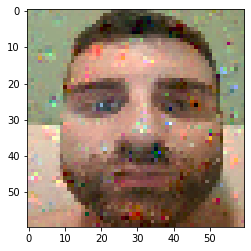

In [21]:
plt.imshow(adv_Image_1.reshape(60,60,3))

So obviously to the human eye this person above does not wear a mask, meaning that our system of models should predict this as 2.

Now let's use our final_prediction function to see what our system of models will predict. In order to do so, we must save the above array as a png file in the directory where this current notebook is saved

In [22]:
imageio.imwrite('adverserial_1.png', adv_Image_1.reshape(60,60,3))

Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


And now let's proceed to the prediction

The original image


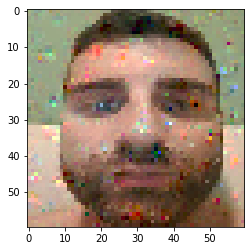

The rescaled image


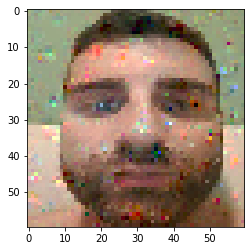

The prediction for that image is: 2


In [23]:
final_prediction('adverserial_1.png')

Our system of models predicted the adversarial example correctly

So in the final notebook called 


(3_OF_3) FINAL_IMPLEMENTATION_MODEL

we will show how to implement our system of models in a x_test, y_test dataset